# E301 Optic 1

In [1]:
import sys
import os
sys.path.insert(0, "../../python")

import numpy as np
from numpy.fft import fft, ifft, fftfreq, fftshift
from scipy.integrate import simps
from scipy.interpolate import interp1d
from scipy.special import erf
from beam.beams import laserpulse
from beam.beams import laserbeam
from beam.elements import plasma
from beam.elements import optic
from beam import interactions
from ionization import ionization
from lens import profile
from lens import bessel
from lens import ray
import matplotlib.pyplot as plt
from lens import design
import numpy.ma as ma
from copy import copy
import matplotlib.colors as colors
plt.style.use('notes')
%load_ext autoreload
%autoreload 2

path = '/mnt/md0/Data/rariniello/E301/E301_1/'
lam = 0.796
tau = 70
# All length units are in um

First design attempt to create a plasma source that has the proper shape to match a beam into a plasma accelerator and accelerate the particle. This notebook looks at the optics tolerances and the propagation through the beam pipe.

In [2]:
plasma_LO, I, z, sim_start, sim_length, pulse = design.load_plasma_design(path)

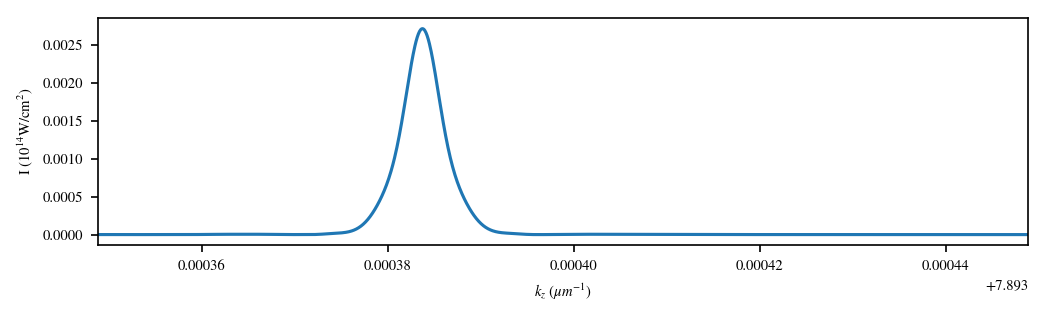

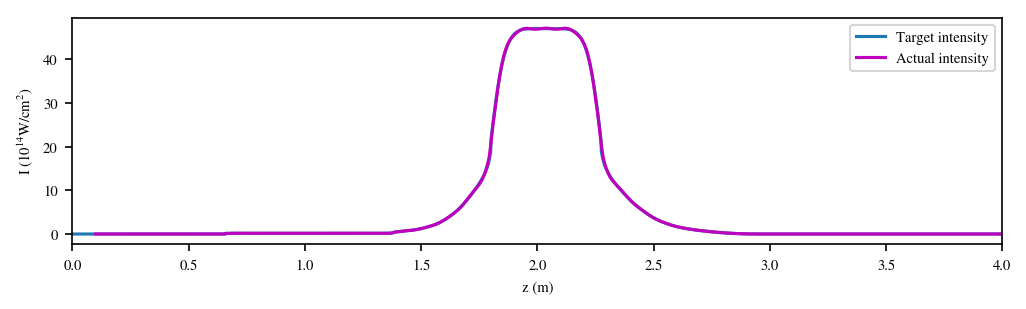

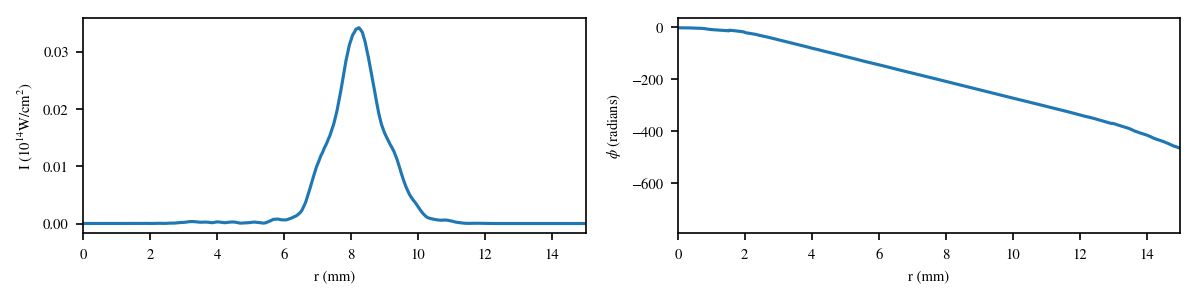

In [3]:
# Optic design upstream
width = 75
xlim = [0, 4]
z0 = 1.6687e6
z_optic, I_optic = design.extend_zI(z0-1e6, 'start', z, I, 0.0, sim_length)
I_optic *= 1
r, E = design.calculate_tran_field(z_optic, I_optic, 20e3, width, lam, path, 10e-5, xlim, [0, 15])

In [4]:
L = 2e6
R_max = 30e3
X = 60e3
Nx = 2**13

n = 8
w0 = 25e3
ri = np.linspace(0, R_max, 5000)
Ei = np.exp(-(ri/w0)**n)
rA, phiA, lensA, multi = design.create_lens_A(ri, Ei, r, E, L, path, lam, X, Nx)

Maximum phase change in one pixel 0.06 rad/um


Total input energy 221.14mJ


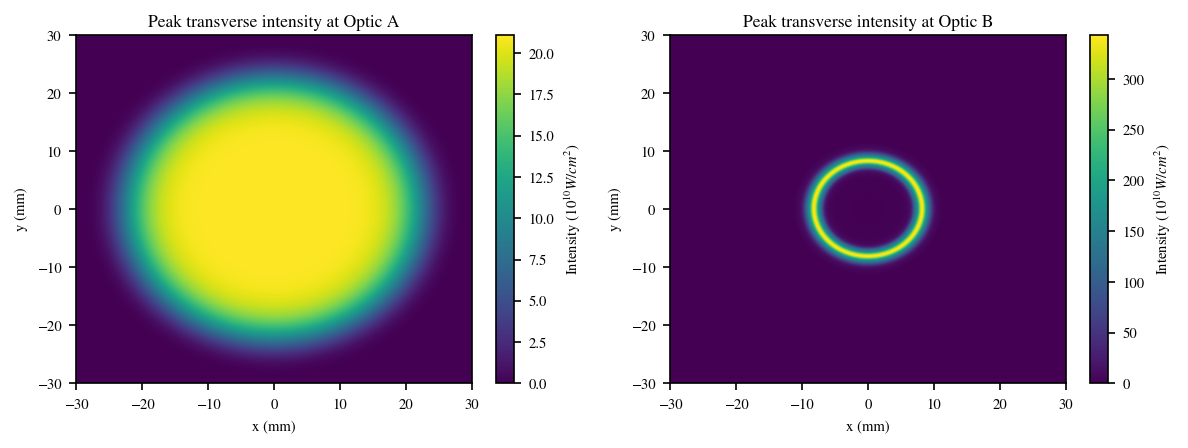

In [5]:
r0 = ri
E0 = Ei#*multi
beam0 = design.propagate_to_lens_B(r0, E0, L, path, lam, lensA, tau, 20)

Maximum phase change in one pixel 0.20 rad/um


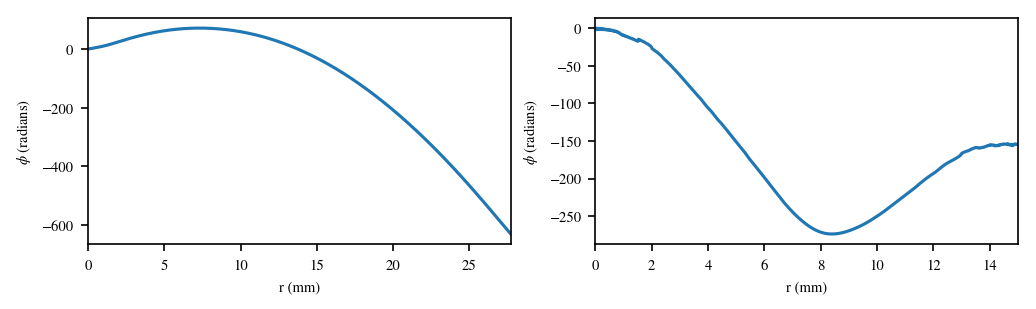

In [6]:
Nx = 2**13
X = 30e3
rB, phiB, lensB = design.create_lens_B(beam0, r, E, path, lam, X, Nx)
design.plot_phase(rA, phiA, rB, phiB, [0, 15])

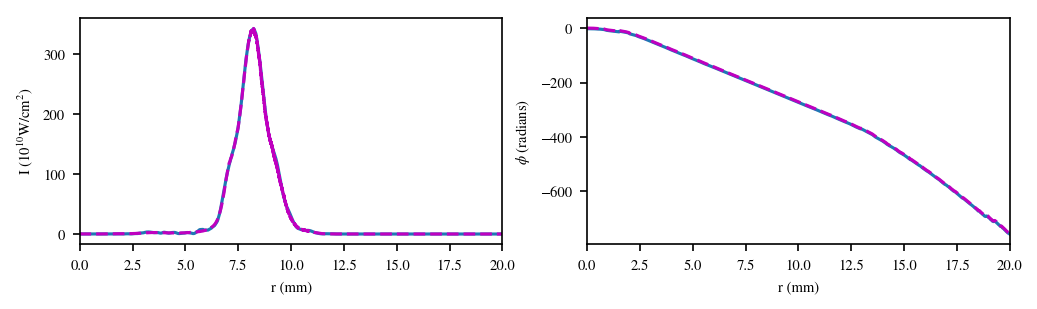

In [7]:
r1, e1 = design.field_after_lens_B(beam0, rB, phiB, r, E, [0, 20])

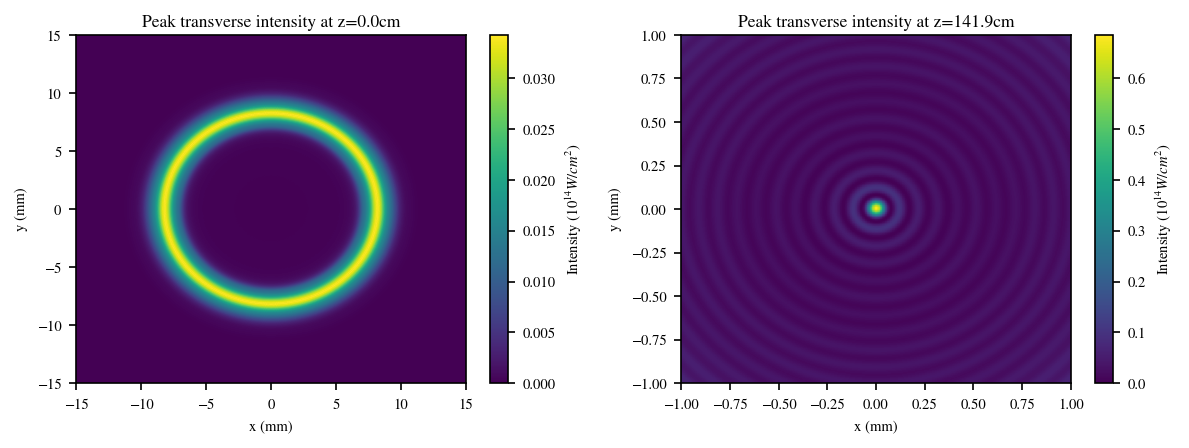

In [8]:
X = 30e3
Nx = 2**13
beam_start, pulseParams = design.propagate_to_start(r1, e1, z0-25e4, X, Nx, path, lam, tau, 20, [-1, 1])

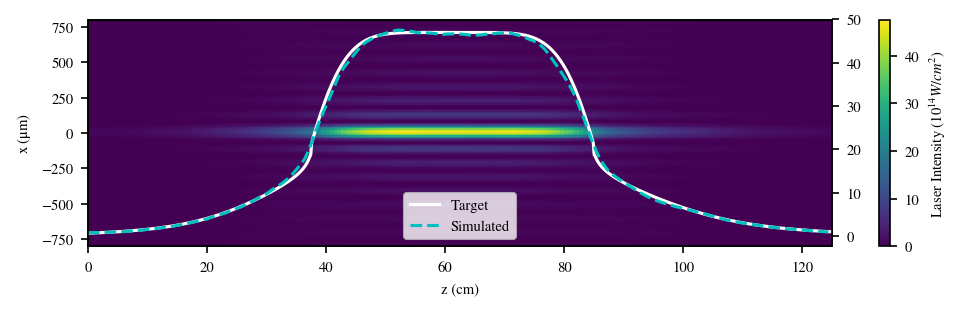

In [9]:
Nx = 2**11
Nz = 200
X = 20e3
Z = sim_length*1e6
I_0 = design.domain_test(X, Nx, Z, Nz, beam_start, pulseParams, z_optic, I_optic, z0+sim_start*1e6, [-800, 800])

In [10]:
# First Optic A to Optic B
XA = lensA.X
NxA = lensA.Nx
beamParams = {'Nx' : NxA,
              'Ny' : NxA,
              'X' : XA,
              'Y' : XA,
              'lam' : lam,
              'path' : path,
              'name' : 'Beam0_A_to_B',
              'threads' : 20,
              'cyl' : True,
              'load' : False}

# Super Gaussian for simulation
Nz0 = 400
z_ab = np.linspace(0, L, Nz0)
beam = laserbeam.Laser(beamParams)
e = beam.reconstruct_from_cyl(r0, E0, beam.x, beam.y)
beam.initialize_field(e)
I0 = ionization.intensity_from_field(E0)
print('Total input energy %0.2fmJ' % (beam.total_cyl_power(r0, I0)*tau))
interactions.beam_phase(beam, lensA)
beam.propagate(z_ab, 1.0)

I_ab = np.zeros((Nz0, NxA))
for i in range(Nz0):
    I_ab[i, :] = beam.intensity_from_field(beam.load_field(i+1)[0])
I_ab = beam.prep_data(I_ab)

XB = lensB.X
NxB = lensB.Nx
pulseParams = {
    'Nt' : 2**6,
    'Nx' : NxB,
    'Ny' : NxB,
    'X' : XB,
    'Y' : XB,
    'T' : 3*tau,
    'lam' : lam,
    'path' : path,
    'load' : False,
    'threads' : 20,
    'cyl' : True,
    'tau' : tau,
    'name' : 'To_Start',
}
Z1 = z0
beam = laserbeam.Laser(pulseParams)
e = beam.reconstruct_from_cyl(r1, e1, beam.x, beam.y)
beam.initialize_field(e)
Nz1 = 400
z_bLO = np.linspace(0, Z1, Nz1)
beam.propagate(z_bLO, 1)

I_bLO = np.zeros((Nz1, NxB))
for i in range(Nz1):
    I_bLO[i, :] = beam.intensity_from_field(beam.load_field(i)[0])
I_bLO = beam.prep_data(I_bLO)

XP = X
NxP = 2**11
NzP = 400
Z_p =  sim_length*1e6
ne0 = 3.5e16
n = lambda z: ne0/1e17
#pulseParams['Nt'] = 2
pulse2, I, ne = design.plasma_refraction(XP, NxP, Z_p, NzP, beam, pulseParams, ionization.He, n, sim_start*1e6, 1,
                                        ne0/1e17, name='Plasma')

ext = [0, Z_p/1e4, -XP/2, XP/2]

I_p = np.zeros((NzP, NxP))
for i in range(NzP):
    I_p[i, :] = np.amax(pulse2.intensity_from_field(pulse2.load_field(i)[0]), axis=0)
I_p = pulse2.prep_data(I_p)

NxD = 2**11
XD = 30e3
NzD = 400
ZD = 2e6
I_D = design.propagate_down_beampipe(pulse2, [0.885e6, 1.186e6, ZD], [4e3, 5e3, 20e3], XD, NxD, NzD)

import numpy.ma as ma
from copy import copy
def prep_ma(Z, X, Nzi, Zi, Z0i, Xi, Nxi, array):
    
    # Calculate the size of the extended array
    Nx = int(Nxi*X/Xi)
    Nz = int(Nzi*Z/Zi)
    # Extend the array to fill the entire imshow with the correct spacing
    Im = np.zeros((Nx, Nz))
    Im = ma.asarray(Im)
    # Mark the entire array as invalid
    Im[:, :] = ma.masked
    # Fill in the intensity 
    Nx0 = int((Nx-Nxi)/2)
    Nz0 = int(Nzi*Z0i/Zi)
    Im[Nx0:Nx0+Nxi, Nz0:Nz0+Nzi] = array
    return Im

Z = L+Z1+Z_p+ZD
X = XA
ext0 = [0, Z/1e3, -X/2e3, X/2e3]
I0m = prep_ma(Z, X, Nz0, L, 0.0, XA, NxA, I_ab)
I1m = prep_ma(Z, X, Nz1, Z1, L, XB, NxB, I_bLO)
I2m = prep_ma(Z, X, NzP, Z_p, L+Z1, XP, NxP, I_p)
I3m = prep_ma(Z, X, NzD, ZD, L+Z1+Z_p, XD, NxD, I_D)

Total input energy 221.14mJ
Initial pulse energy 218.86mJ
Final pulse energy 217.84mJ


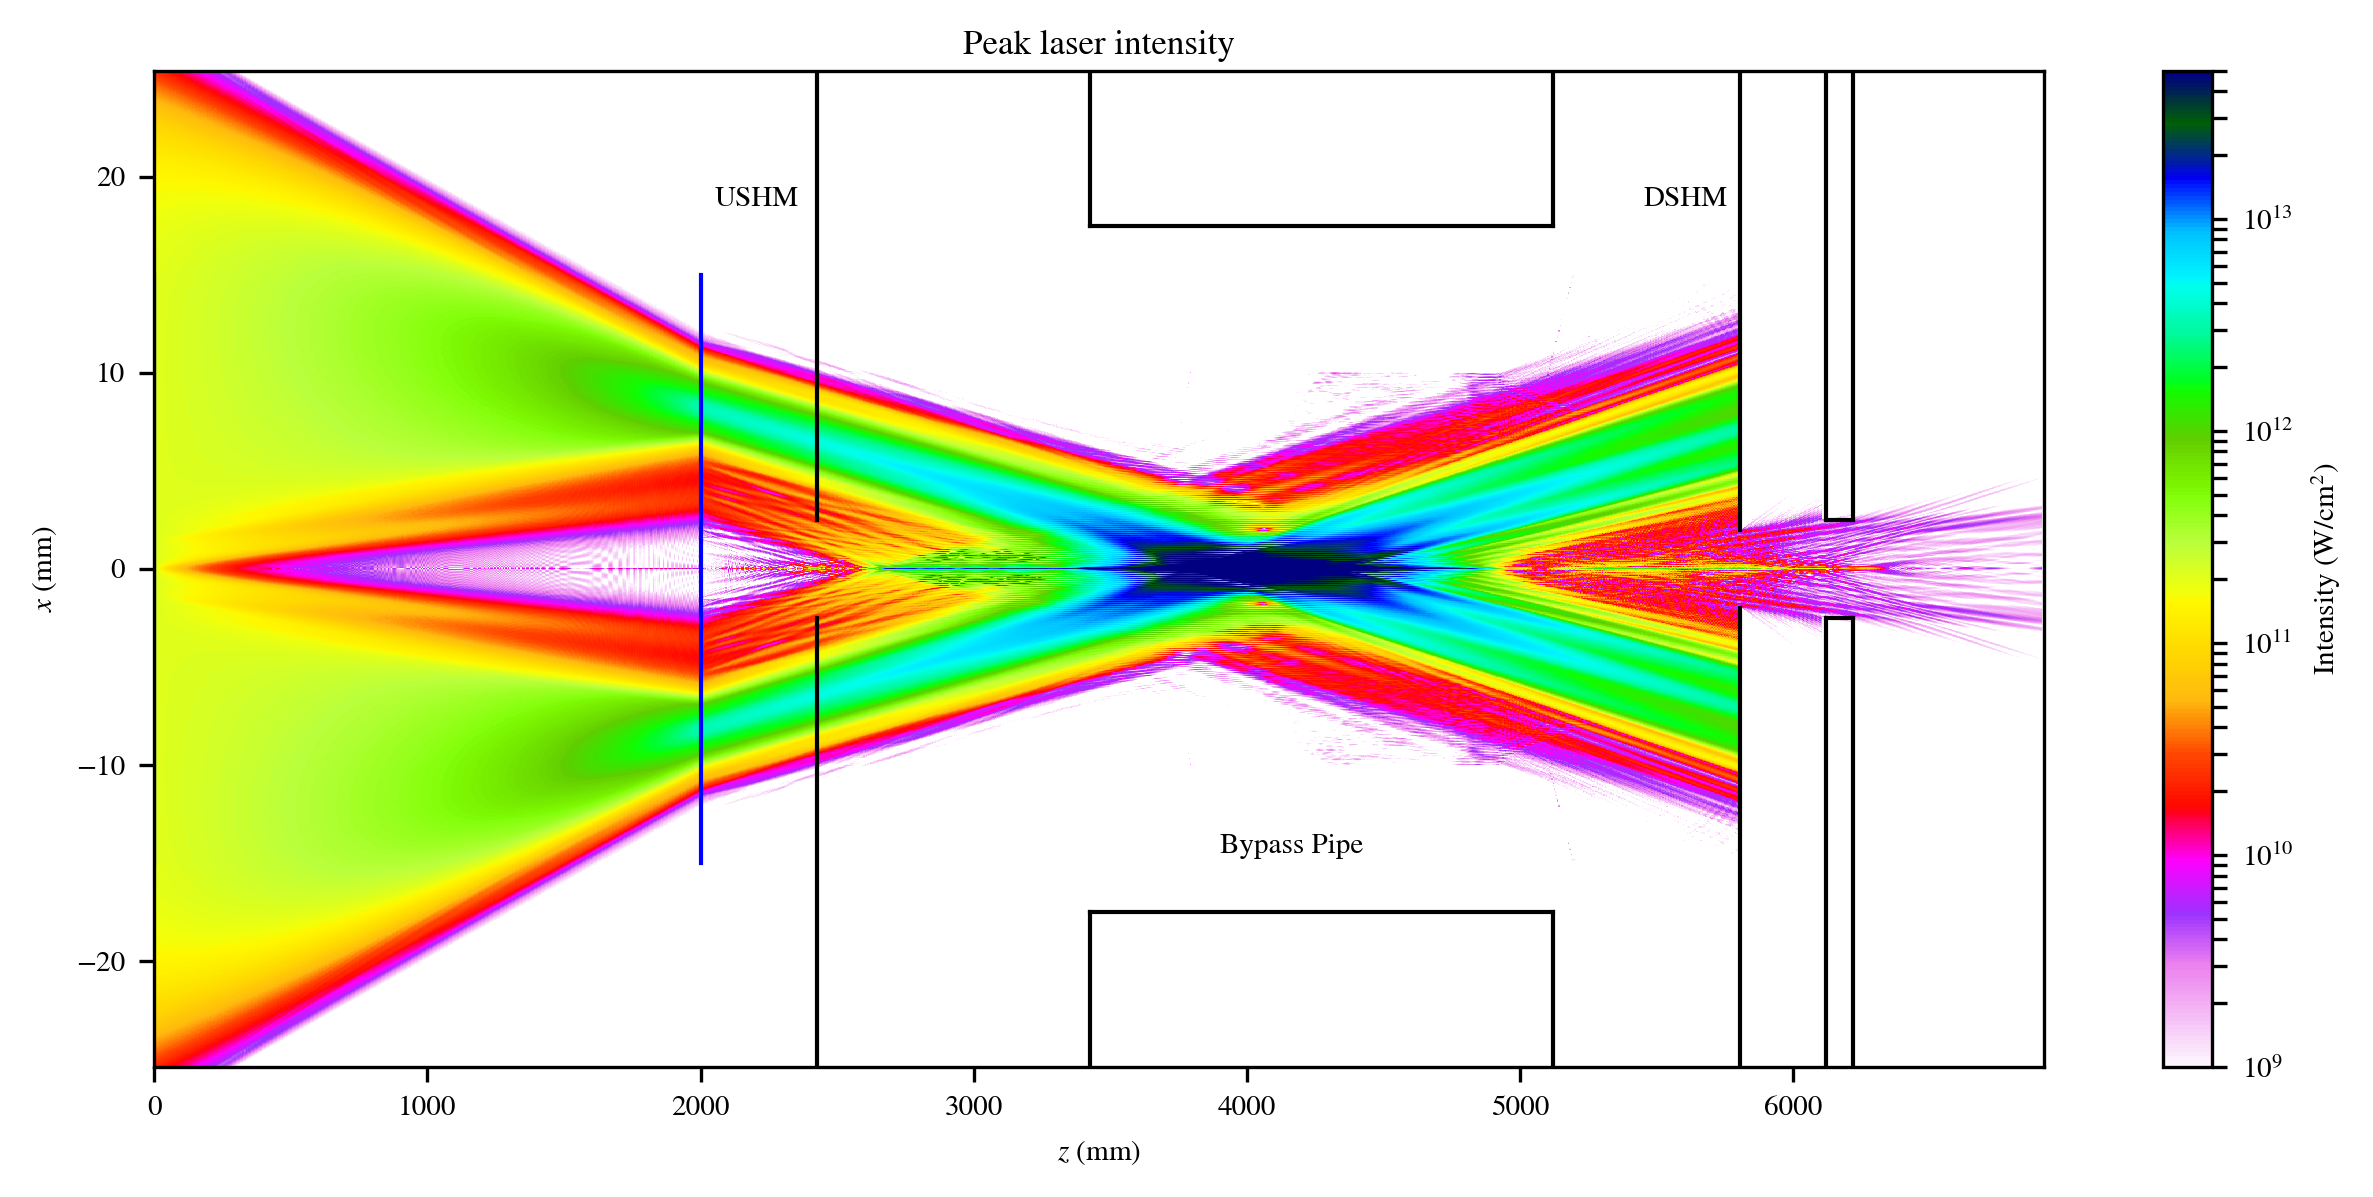

In [17]:
plt.figure(figsize=(8.5, 4), dpi=300)
palette = copy(plt.cm.gist_ncar_r)
palette.set_bad('w', 0.0)
palette.set_under('w', 1.0)
norm = colors.LogNorm(vmin=1e9, vmax=5e13)
im = plt.imshow(I_ab, aspect='auto', extent=ext0, norm=norm)
plt.imshow(I0m*1e14, aspect='auto', extent=ext0, norm=norm)
plt.imshow(I1m*1e14, aspect='auto', extent=ext0, norm=norm)
plt.imshow(I2m*1e14, aspect='auto', extent=ext0, norm=norm)
plt.imshow(I3m*1e14, aspect='auto', extent=ext0, norm=norm)
cb = plt.colorbar()
cb.set_label(r'Intensity ($\mathrm{W/cm^2}$)')
plt.set_cmap(palette)
plt.xlabel(r'$z$ (mm)')
plt.ylabel(r'$x$ (mm)')
plt.title('Peak laser intensity')
plt.ylim(-25.4, 25.4)

# Optic A and Optic B
plt.plot([0, 0], [-15, 15], 'b-', lw=1)
plt.plot([L/1e3, L/1e3], [-15, 15], 'b-', lw=1)
# USHM
dz = 425
plt.plot([L/1e3+dz, L/1e3+dz], [-25.4, -2.5], 'k-', lw=1)
plt.plot([L/1e3+dz, L/1e3+dz], [25.4, 2.5], 'k-', lw=1)
plt.text(2050, 18.5, 'USHM')
# LO pipe
dz = 1424.6
l = 1695.5
w = 17.5
plt.plot([L/1e3+dz, L/1e3+dz], [-25.4, -w], 'k-', lw=1)
plt.plot([L/1e3+dz, L/1e3+dz], [25.4, w], 'k-', lw=1)
plt.plot([L/1e3+dz, L/1e3+dz+l], [-w, -w], 'k-', lw=1)
plt.plot([L/1e3+dz, L/1e3+dz+l], [w, w], 'k-', lw=1)
plt.plot([L/1e3+dz+l, L/1e3+dz+l], [-25.4, -w], 'k-', lw=1)
plt.plot([L/1e3+dz+l, L/1e3+dz+l], [25.4, w], 'k-', lw=1)
plt.text(3900, -14.5, 'Bypass Pipe')
# DSHM
p_end = L/1e3+z0/1e3+1250
dz = p_end+885
plt.plot([dz, dz], [-25.4, -2], 'k-', lw=1)
plt.plot([dz, dz], [25.4, 2], 'k-', lw=1)
plt.text(5450, 18.5, 'DSHM')
# Plasma
#plt.plot([p_end-800, p_end], [-10, -10], 'k-', lw=1)
# Differential Pumping
dz = p_end+1200
l = 100
plt.plot([dz, dz], [-25.4, -2.5], 'k-', lw=1)
plt.plot([dz, dz], [25.4, 2.5], 'k-', lw=1)
plt.plot([dz, dz+l], [-2.5, -2.5], 'k-', lw=1)
plt.plot([dz, dz+l], [2.5, 2.5], 'k-', lw=1)
plt.plot([dz+l, dz+l], [-25.4, -2.5], 'k-', lw=1)
plt.plot([dz+l, dz+l], [25.4, 2.5], 'k-', lw=1)

#plt.plot([p_end-400])
plt.tight_layout()
plt.show()